In [1]:
# Importy
from PIL import Image
import os
import matplotlib.pyplot as plt
import tensorflow as tf 
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras import Model
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
# Wyświetl strukturę bazy i przykładowe dane w zbiorze

metadata_path = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv"
metadata = pd.read_csv(metadata_path)

pd.options.display.max_colwidth = 100

print(metadata.sample(20))
print(metadata.info())

        lesion_id      image_id   dx    dx_type   age     sex     localization
5410  HAM_0001939  ISIC_0025468   nv  follow_up  70.0    male  lower extremity
1509  HAM_0007368  ISIC_0032017  mel      histo  70.0    male             face
4079  HAM_0005281  ISIC_0028908   nv  follow_up  60.0  female  lower extremity
8996  HAM_0001936  ISIC_0024704   nv      histo  80.0  female  lower extremity
8416  HAM_0005818  ISIC_0032427   nv      histo  50.0    male             back
1775  HAM_0004578  ISIC_0034239  mel      histo  85.0    male  lower extremity
3326  HAM_0002276  ISIC_0025366  bkl  consensus  50.0  female            trunk
3672  HAM_0004135  ISIC_0025634   nv  follow_up  45.0  female  upper extremity
3177  HAM_0000557  ISIC_0025675   nv  follow_up  50.0  female  upper extremity
9462  HAM_0005263  ISIC_0033247   nv  consensus  40.0    male            trunk
5830  HAM_0007282  ISIC_0025690   nv  follow_up  50.0    male          abdomen
839   HAM_0001781  ISIC_0029823  bkl  consensus  30.

In [3]:
# Zapisywanie ścieżek obrazów w kolumnie path 

image_dir_part_1 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1"
image_dir_part_2 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2"

metadata['path'] = metadata['image_id'].apply(
    lambda x: os.path.join(image_dir_part_1, x + ".jpg")
    if os.path.exists(os.path.join(image_dir_part_1, x + ".jpg"))
    else os.path.join(image_dir_part_2, x + ".jpg")
)

In [4]:
# Funkcja do wyświetlania przykładów obrazów z konkretnej klasy
def plot_samples(class_name):
    metadata_class = metadata.loc[metadata['dx'] == class_name]

    sample_indices = random.sample(range(len(metadata_class)), 5)
    plt.figure(figsize=(20, 8))

    for i, idx in enumerate(sample_indices):
        img_path = metadata_class.iloc[idx]['path']
        img = Image.open(img_path)

        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Opis klas w zbiorze

## AKIEC 
- uszkodzenia skóry przez promieniowanie słoneczne - rogowacenie słoneczne, rak śródnabłonkowy (choroba Bowena)
- nieinwazyjny wariant raka płaskonabłonkowego
- leczenie miejscowo bez operacji
- może przekształcić się w inwazyjnego raka kolczystokomórkowego
- łuszczenie powierzchniowe i pozbawienie pigmentu




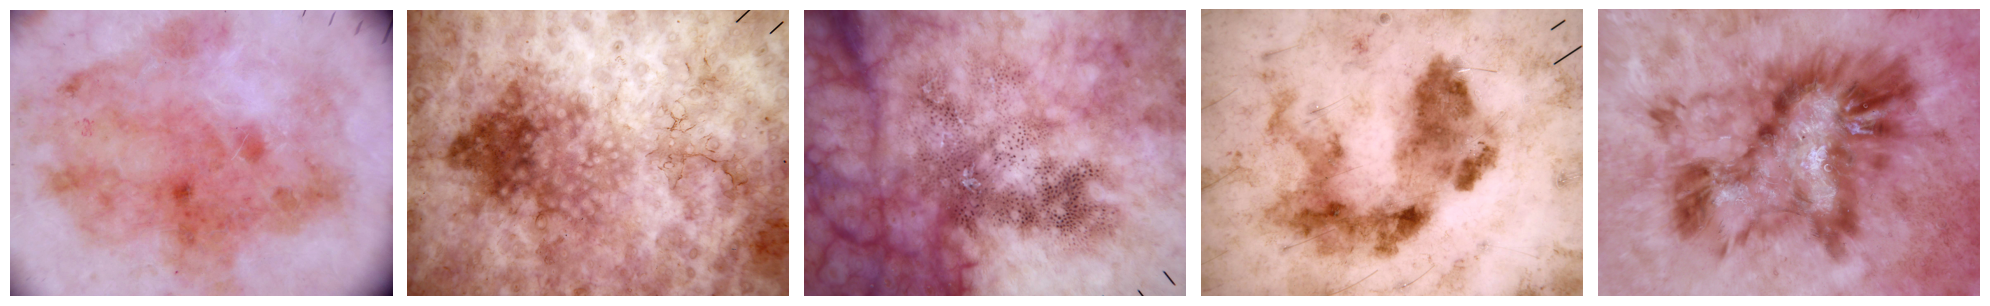

In [5]:
# Wyświetl obrazy z klasy akiec
plot_samples(class_name='akiec')

## BCC 
- rak podstawnokomórkowy
- najczęściej występujący rodzaj raka skóry
- leczenie miejscowo bez operacji
- nieleczony może stać się miejscowo inwazyjny

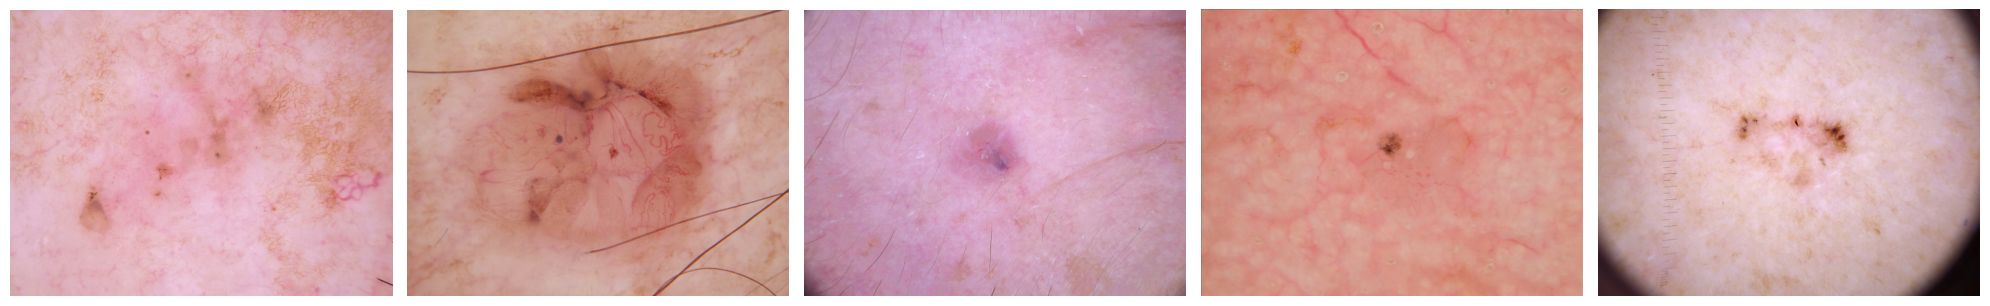

In [6]:
# Wyświetl obrazy z klasy bcc
plot_samples(class_name='bcc')

## BKL
- nieszkodliwe rogowacenie - brodawki łojotokowe, plama soczewicowata, liszaj płaski
- mogą pojawić się w wyniku starzenia się skóry
- jasnobrązowe i ciemnobrązowe (w przypadku liszaju zaczerwienione), często owalne plamy
- leczenie miejscowe lub brak leczenia


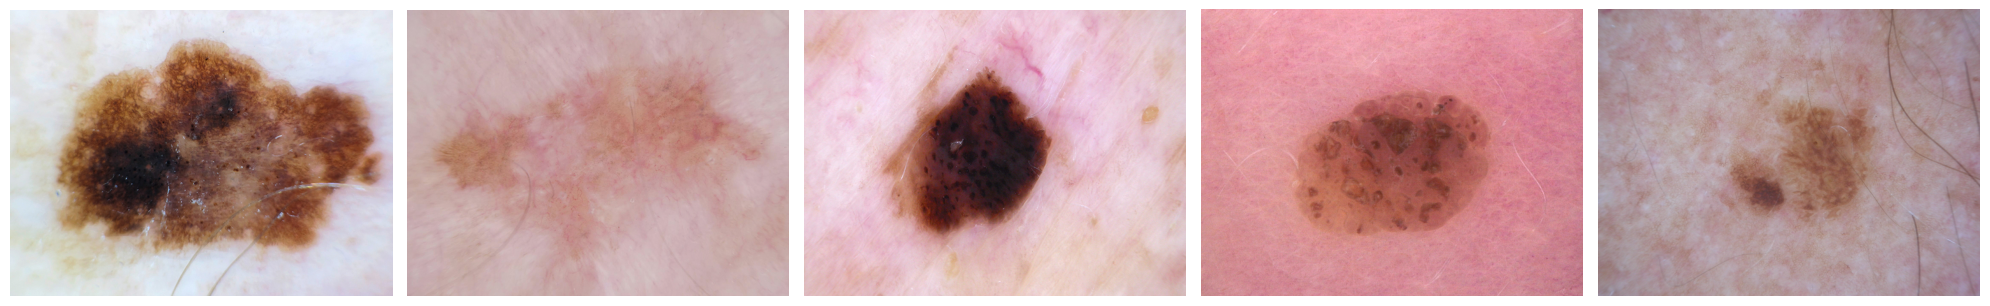

In [7]:
# Wyświetl obrazy z klasy bkl
plot_samples(class_name='bkl')

## DF
- dermatofibroma - włókniak twardy
- niegroźny, bezbolesny guz
- brak leczenia lub leczenie ze względów estetycznych

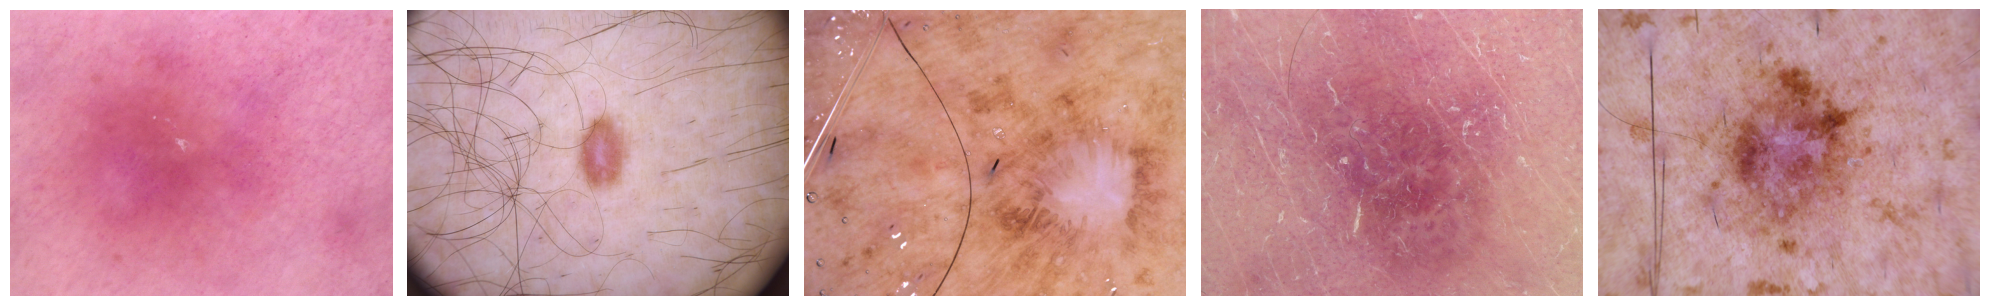

In [8]:
# Wyświetl obrazy z klasy df
plot_samples(class_name='df')

## NV
- znamie melanocytowe - pieprzyk
- zwykle nieszkodliwy guz melanocytowy
- ciemny kolor
- brak leczenia lub leczenie ze względów estetycznych

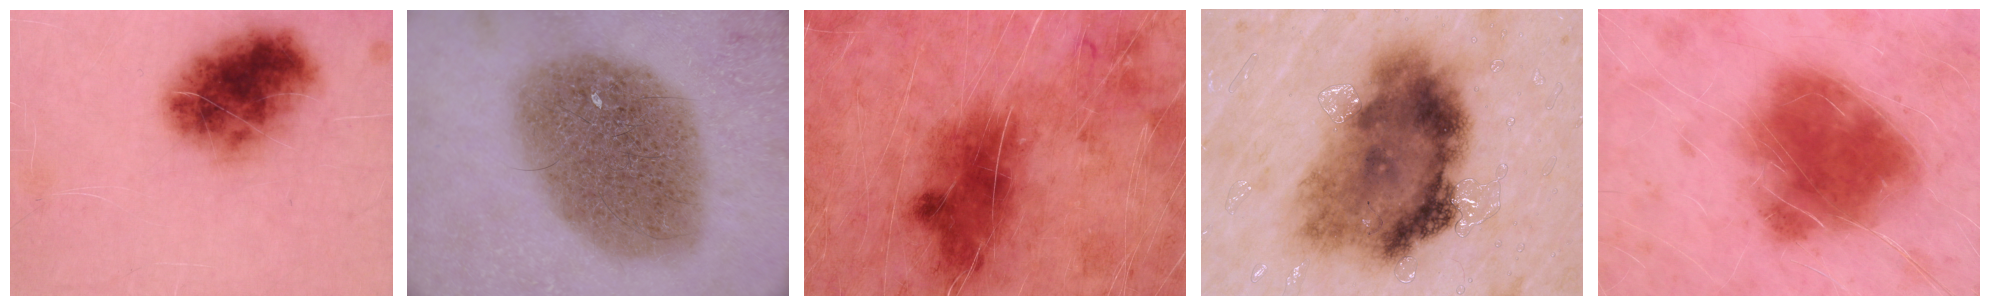

In [9]:
# Wyświetl obrazy z klasy nv
plot_samples(class_name='nv')

## MEL
- czerniak
- złośliwy nowotwór skóry
- asymetryczne zabarwienie, nieregularne ograniczenie zmiany, duży wymiar
- może występować świąd, ból, krwawienie
- konieczne leczenie chirurgiczne (wycięcie)

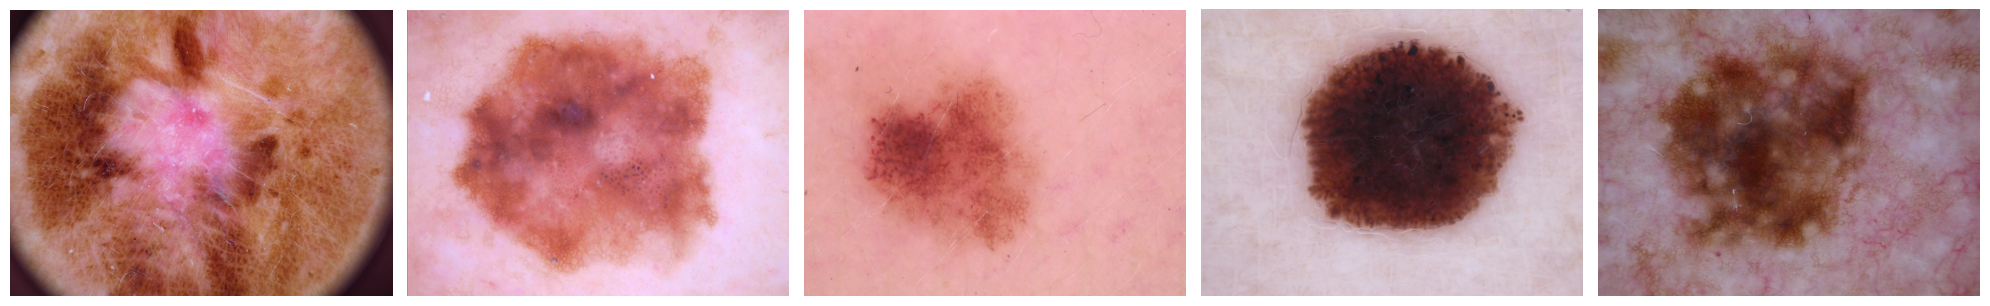

In [10]:
# Wyświetl obrazy z klasy mel
plot_samples(class_name='mel')

## VASC
- nieszkodliwe naczyniowe zmiany skórne - naczyniaki wiśniowe, rogowiec krwawy, ziarniniak ropotwórczy
- czerwony i fioletowy kolor, solidnie ograniczone struktury
- leczenie miejscowe lub brak leczenia

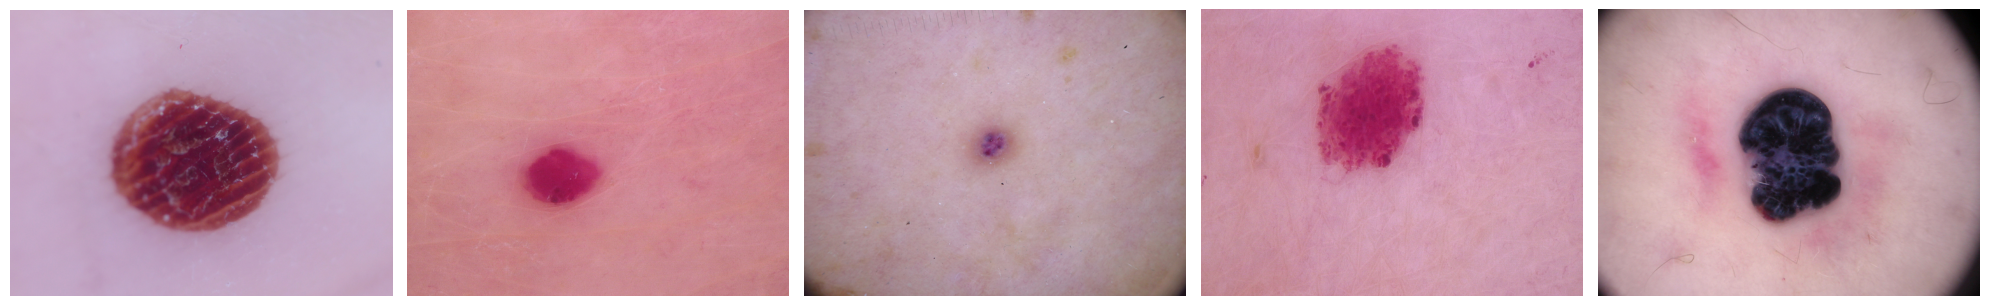

In [11]:
# Wyświetl obrazy z klasy vasc
plot_samples(class_name='vasc')

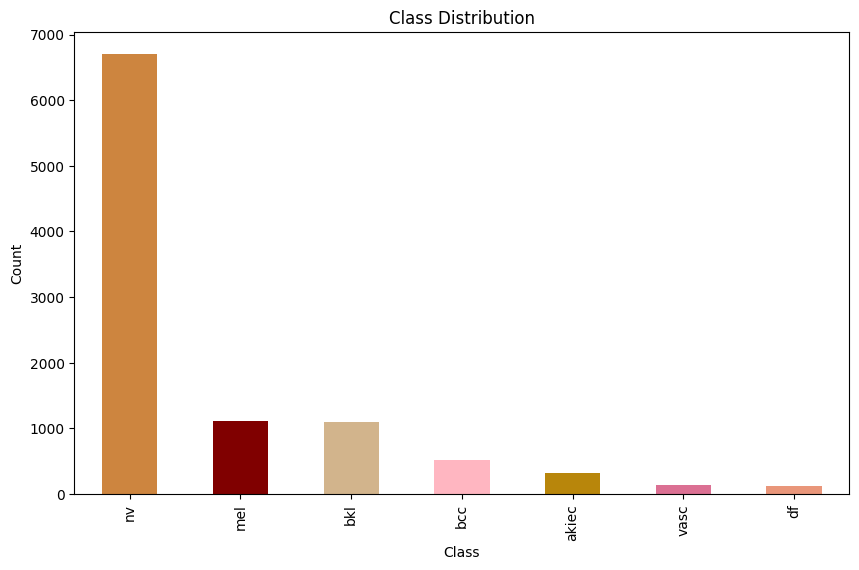

In [12]:
# Wizualizacja dystrybucji klas w zbiorze

class_counts = metadata['dx'].value_counts()

colors = ['peru', 'maroon', 'tan', 'lightpink', 'darkgoldenrod', 'palevioletred', 'darksalmon']

plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color=colors)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [13]:
# Podzielenie zbioru na zbiór uczący, walidujący i testowy

train_df, temp_df = train_test_split(metadata, test_size=0.4, stratify=metadata['dx'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['dx'], random_state=42)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")

Train size: 6009, Validation size: 2003, Test size: 2003


In [14]:
# Stworzenie ImageDataGenerator, odpowiedzialnego za przetwarzanie i losową augumentację obrazów podczas trenowania

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Stworzenie generatorów dostarczających dane (klasa, obraz) podczas trenowania na bazie datagen

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='path',
    y_col='dx',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col='path',
    y_col='dx',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='path',
    y_col='dx',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 6009 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.


In [15]:
# Załadowanie modelu EfficientNetB0

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
print(base_model.input_shape)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(None, 224, 224, 3)


In [16]:
x = base_model.output

# Nałożenie warstwy uśredniającej każdą mapę cech
x = GlobalAveragePooling2D()(x)

# Nałożenie warstwy głębokiej, w której każdy neuron jest połączony z każdym neuronem z poprzedniej warstwy
x = Dense(1024, activation='relu')(x)

predictions = Dense(7, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [17]:
# Optymalizator Adam, klasyfikacja wieloklasowa i metryki

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', AUC(), Precision(), Recall()])

In [18]:
# Early stopping - wczesne zatrzymanie procesu uczenia jeżeli średnia dokładność zbioru testowego zacznie spadać

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=3,
    verbose=1, 
    restore_best_weights=True
)

In [19]:
# Obliczanie wag dla klas

classes = np.unique(train_df['dx'])
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_df['dx'])
class_weight_dict = dict(zip(classes, class_weights))

In [20]:
# Dynamiczne learning rate 

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

In [21]:
# Trenowanie

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight_dict
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


188/188 ━━━━━━━━━━━━━━━━━━━━ 267s 1s/step - accuracy: 0.6346 - auc: 0.8943 - loss: 1.0462 - precision: 0.8021 - recall: 0.4609 - val_accuracy: 0.0170 - val_auc: 0.1518 - val_loss: 2.8374 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 104s 537ms/step - accuracy: 0.7938 - auc: 0.9728 - loss: 0.5678 - precision: 0.8687 - recall: 0.7238 - val_accuracy: 0.0439 - val_auc: 0.1520 - val_loss: 2.8855 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 104s 534ms/step - accuracy: 0.8349 - auc: 0.9842 - loss: 0.4344 - precision: 0.8874 - recall: 0.7869 - val_accuracy: 0.1293 - val_auc: 0.3694 - val_loss: 2.4556 - val_precision: 0.5912 - val_recall: 0.0469 - learning_rate: 1.0000e-04
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 104s 534ms/step - accuracy: 0.8679 - auc: 0.9888 - loss: 0.3619 - precision: 0.9031 - recall: 0.8319 - val_accuracy: 0.7454 - val_auc: 0

In [22]:
# Testowanie

test_history = model.evaluate(test_generator)
test_loss = test_history[0]
test_acc = test_history[1]
print(f"Test loss: {test_loss}, Test accuracy: {test_acc}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 425ms/step - accuracy: 0.8216 - auc: 0.9759 - loss: 0.5168 - precision: 0.8400 - recall: 0.8013
Test loss: 0.5263246893882751, Test accuracy: 0.8207688331604004


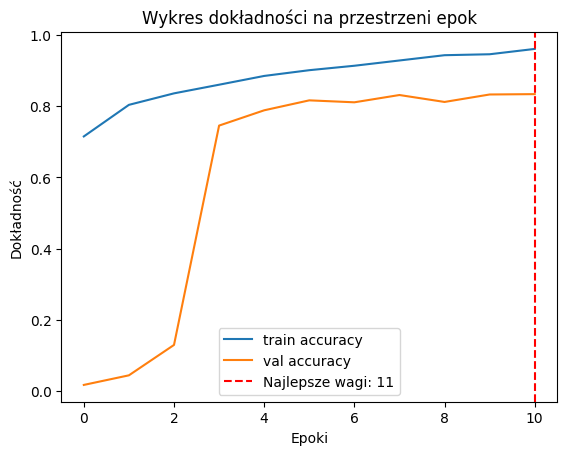

In [23]:
# Wykres dokładności na przestrzeni epok

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')

best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy']))

plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Najlepsze wagi: {best_epoch+1}')
plt.xlabel('Epoki')
plt.ylabel('Dokładność')
plt.title('Wykres dokładności na przestrzeni epok')
plt.legend()
plt.show()

In [24]:
# Metryki całkowite i dla klas

test_images = []
test_labels = []
class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

for i in range(len(test_generator)):
    images, labels = test_generator[i]
    test_images.extend(images)
    test_labels.extend(labels)

test_images = np.array(test_images)
test_labels = np.array(test_labels)

true_labels = np.argmax(test_labels, axis=1)
predicted_probs = model.predict(test_images)
predicted_labels = np.argmax(predicted_probs, axis=1)

report = classification_report(true_labels, predicted_labels, target_names=class_names)
print(report)

63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step
              precision    recall  f1-score   support

       akiec       0.79      0.35      0.48        66
         bcc       0.90      0.46      0.61       103
         bkl       0.56      0.81      0.66       219
          df       0.71      0.52      0.60        23
         mel       0.56      0.59      0.57       223
          nv       0.92      0.92      0.92      1341
        vasc       1.00      0.71      0.83        28

    accuracy                           0.82      2003
   macro avg       0.78      0.62      0.67      2003
weighted avg       0.84      0.82      0.82      2003



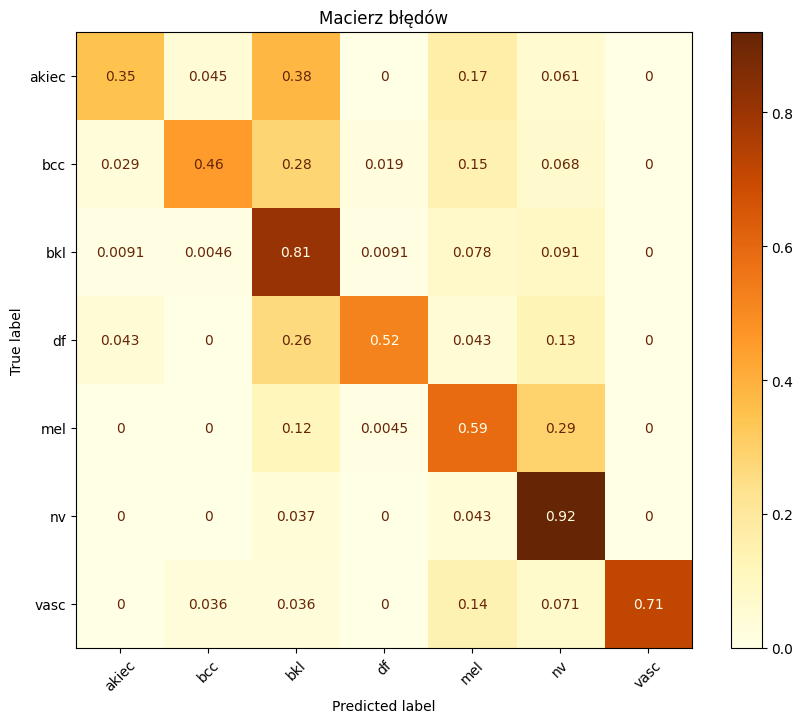

In [25]:
# Macierz błędów
cm = confusion_matrix(true_labels, predicted_labels, normalize='true')

fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='YlOrBr', xticks_rotation=45, ax=ax)
plt.title('Macierz błędów')
plt.show()

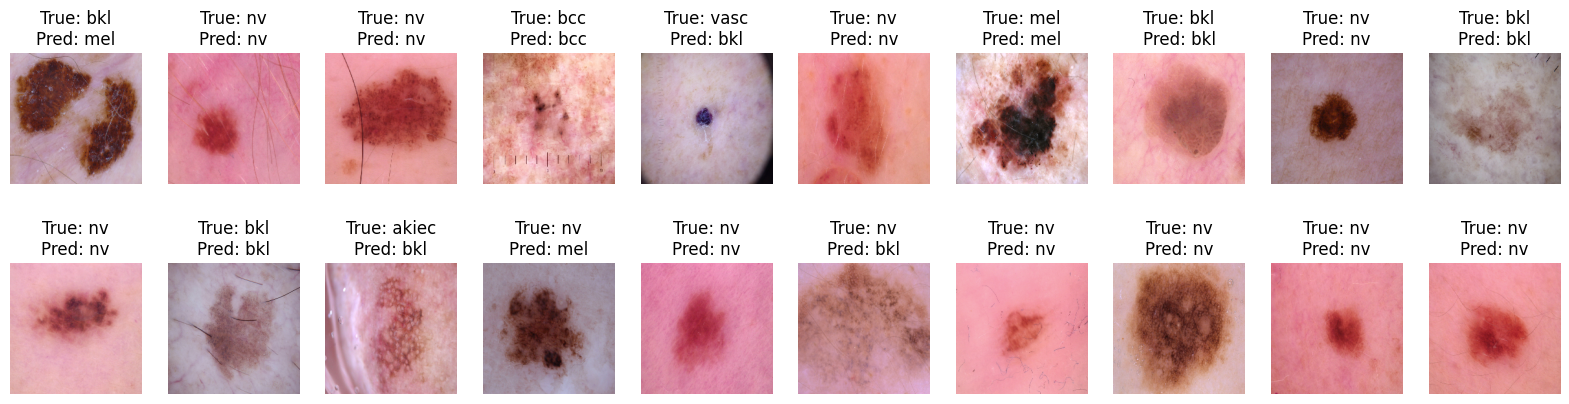

In [27]:
# Przykładowe klasyfikacje

def plot_results(images, true_labels, predicted_labels, class_names, num_samples):
    plt.figure(figsize=(20, 5))
    for i in range(num_samples):
        plt.subplot(2, num_samples//2, i+1)
        plt.imshow(images[i])
        plt.title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[predicted_labels[i]]}")
        plt.axis('off')
    plt.show()

num_samples = 20
sample_indices = np.random.choice(len(test_images), num_samples, replace=False)
sample_images = test_images[sample_indices]
sample_true_labels = true_labels[sample_indices]
sample_predicted_labels = predicted_labels[sample_indices]

plot_results(sample_images, sample_true_labels, sample_predicted_labels, class_names, num_samples)